In [1]:
import sys

assert sys.version_info >= (3, 7)

In [2]:
from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [4]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "U-Net"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [5]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardwar "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Acclerator and select GPU.")

In [6]:
import glob
import numpy as np
import cv2
from os.path import splitext
from os import listdir
import random

imgs_dir = 'datasets/oxford_iiit_pets/images/'
masks_dir = 'datasets/oxford_iiit_pets/trimaps/'

filenames = [splitext(file)[0] for file in listdir(imgs_dir)
             if not file.startswith('.')]

random.shuffle(filenames)

In [7]:
n_total = len(filenames)
test_percent = 0.3
n_test = round(n_total * test_percent)
n_train_full = n_total - n_test

X_train_full = np.empty((n_train_full, 128, 128, 3), dtype=np.uint8)
y_train_full = np.empty((n_train_full, 128, 128, 3), dtype=np.uint8)
for i in range(n_train_full):
    filename = filenames[i]
    img = cv2.imread(imgs_dir + filename + '.jpg')
    mask = cv2.imread(masks_dir + filename + '.png')

    img = cv2.resize(img, dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
    mask = cv2.resize(mask, dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
    X_train_full[i] = img
    y_train_full[i] = mask

X_test = np.empty((n_test, 128, 128, 3), dtype=np.uint8)
y_test = np.empty((n_test, 128, 128, 3), dtype=np.uint8)
for i in range(n_train_full, n_total):
    filename = filenames[i]
    img = cv2.imread(imgs_dir + filename + '.jpg')
    mask = cv2.imread(masks_dir + filename + '.png')
    
    img = cv2.resize(img, dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
    mask = cv2.resize(mask, dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
    X_train_full[i-n_train_full] = img
    y_train_full[i-n_train_full] = mask

In [8]:
X_valid, X_train = X_train_full[:500], X_train_full[500:]
y_valid, y_train = y_train_full[:500], y_train_full[500:]

In [9]:
tf.random.set_seed(42)
with tf.device('/CPU:0'):
    train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train_set = train_set.shuffle(len(X_train), seed=42)
    valid_set = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
    test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [10]:
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Feature, Features, Example

def create_example(img, mask):
    img_data = tf.io.serialize_tensor(img)
    mask_data = tf.io.serialize_tensor(mask)
    return Example(
        features=Features(
            feature={
            "image": Feature(bytes_list=BytesList(value=[img_data.numpy()])),
            "mask": Feature(bytes_list=BytesList(value=[mask_data.numpy()]))
        })
    )

In [11]:
for image, mask in valid_set.take(1):
    print(create_example(image, mask))

features {
  feature {
    key: "image"
    value {
      bytes_list {
        value: "\010\004\022\016\022\003\010\200\001\022\003\010\200\001\022\002\010\003\"\200\200\003\360\336\341\356\335\340\360\340\343\361\340\343\361\340\343\361\340\343\362\341\344\363\342\345\363\342\345\364\343\346\365\344\350\363\346\347\365\347\351\365\347\351\366\350\352\366\350\352\366\350\352\367\351\353\370\352\354\367\351\353\370\352\354\371\353\354\372\354\356\372\354\356\372\354\356\372\354\356\371\354\356\372\355\357\373\356\360\373\356\360\374\357\361\374\357\361\374\357\361\374\357\361\375\360\362\375\360\362\374\361\363\375\360\362\374\361\363\376\361\363\374\361\363\374\361\363\375\362\364\373\360\361\316\257\245\031\022\027\026\017\024\023\017\017\030\022\025+\037 2\033 \362\334\335\376\366\364\375\362\364\375\365\366\375\365\366\375\365\366\375\365\366\375\365\366\375\365\366\376\366\367\375\365\366\376\366\367\375\366\367\376\366\367\376\366\367\375\366\367\373\365\366\374\366\367\377\367\37

In [12]:
from contextlib import ExitStack

def write_tfrecords(name, dataset, n_shards=10):
    paths = ["{}.tfrecord-{:05d}-of-{:05d}".format(name, index, n_shards)
             for index in range(n_shards)]
    with ExitStack() as stack:
        writers = [stack.enter_context(tf.io.TFRecordWriter(path))
                   for path in paths]
        for index, (image, mask) in dataset.enumerate():
            shard = index % n_shards
            example = create_example(image, mask)
            writers[shard].write(example.SerializeToString())
    return paths

In [13]:
with tf.device('/CPU:0'):
    train_filepaths = write_tfrecords("oxford_iiit_pets.train", train_set)
    valid_filepaths = write_tfrecords("oxford_iiit_pets.valid", valid_set)
    test_filepaths = write_tfrecords("oxford_iiit_pets.test", test_set)

In [14]:
def preprocess(tfrecord):
    feature_descriptions = {
        "image": tf.io.FixedLenFeature([], tf.string, default_value=""),
        "mask": tf.io.FixedLenFeature([], tf.string, default_value="")
    }
    example = tf.io.parse_single_example(tfrecord, feature_descriptions)
    image = tf.io.parse_tensor(example["image"], out_type=tf.uint8)
    image = tf.reshape(image, shape=[128, 128, 3])
    mask = tf.io.parse_tensor(example["mask"], out_type=tf.uint8)
    mask = tf.reshape(mask, shape=[128, 128, 3])
    return image, mask

def oxford_iiit_pets_dataset(filepaths, n_read_threads=5, shuffle_buffer_size=None,
                             n_parse_threads=5, batch_size=8, cache=True):
    dataset = tf.data.TFRecordDataset(filepaths,
                                      num_parallel_reads=n_read_threads)
    
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1)

In [15]:
train_set = oxford_iiit_pets_dataset(train_filepaths, shuffle_buffer_size=10_000)
valid_set = oxford_iiit_pets_dataset(valid_filepaths)
test_set = oxford_iiit_pets_dataset(test_filepaths)

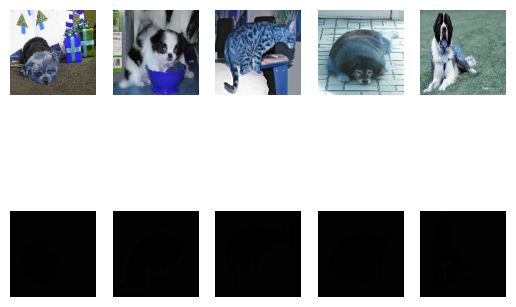

In [16]:
for X, y in train_set.take(1):
    for i in range(5):
        plt.subplot(2, 5, i + 1)
        plt.imshow(X[i].numpy())
        plt.axis('off')
        plt.subplot(2, 5, i + 6)
        plt.imshow(y[i].numpy())
        plt.axis('off')

# U-Net

_U-Net Architecture_

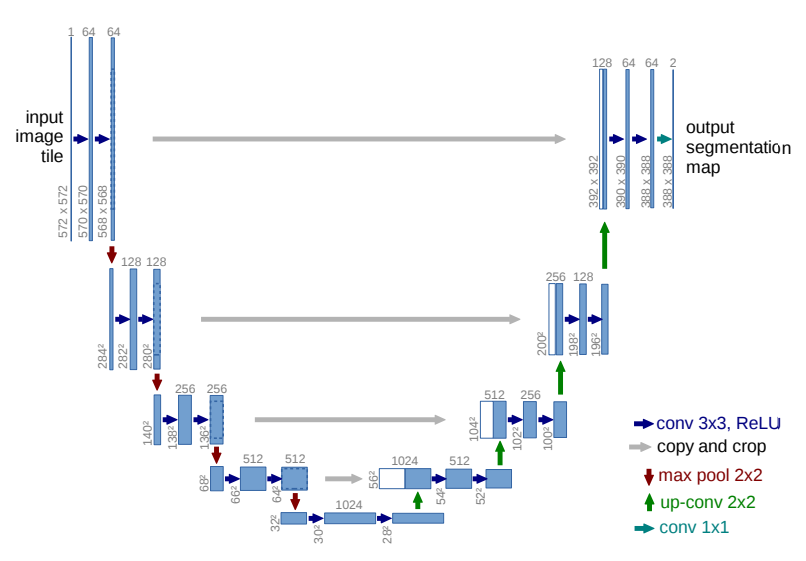

Network Architecture consists of a **contracting path** (left side) and an **expansive path** (right side). The contracting path follows the typical architecture of a convolutional network. It consists of the repeated application of two $3 \times 3$ convolutions (unpadded convolutions), each followed by a rectified linear unit (ReLU) and a $2 \times 2$ max pooling operation with stride 2 for downsampling. At each downsampling step we double the number of feature channels. Every step in the expansive path consists of an upsampling of the feature map followed by a $2 \times 2$ convolution ("up-convolution") that halves the number of feature channels, a concatenation with the correspondingly cropped feature map from the contracting path, and two $3 \times 3$ convolutions, each followed by a ReLU. The cropping is necessary due to the loss of border pixels in every convolution. At the final layer a $1 \times 1$ convolution is used to map each 64-component feature vector to the desired number of classes. In total the network has 23 convolutional layers.

In [17]:
from functools import partial

DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="same", kernel_initializer="he_normal",
                        activation="relu")
DefaultMaxPool2D = partial(tf.keras.layers.MaxPool2D, pool_size=2, strides=2)
DefaultConv2DTranspose = partial(tf.keras.layers.Conv2DTranspose, kernel_size=3, 
                                 strides=2, padding="same")

In [18]:
class MyConv2D(tf.keras.layers.Layer):
    def __init__(self, filters, **kwargs):
        super().__init__(**kwargs)
        # self.conv_layer1 = DefaultConv2D(filters=filters)
        # self.conv_layer2 = DefaultConv2D(filters=filters)

        self.doubleConv = tf.keras.Sequential([
            tf.keras.layers.Conv2D(filters=filters, kernel_size=3, 
                                    strides=1, kernel_initializer="he_normal",
                                    padding="same"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Conv2D(filters=filters, kernel_size=3,
                                    strides=1, kernel_initializer="he_normal",
                                    padding="same"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU()
        ])
    
    def call(self, X):
        return self.doubleConv(X)

In [19]:
norm_layer = tf.keras.layers.Normalization(input_shape=[128, 128, 3])

sample_image_batches = train_set.take(100).map(lambda image, mask: image)
sample_images = np.concatenate(list(sample_image_batches.as_numpy_iterator()),
                               axis=0).astype(np.uint8)
norm_layer.adapt(sample_images)

In [20]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

# Contracting Path
conv_layer1 = MyConv2D(64)
pool_layer1 = DefaultMaxPool2D()

conv_layer2 = MyConv2D(128)
pool_layer2 = DefaultMaxPool2D()

conv_layer3 = MyConv2D(256)
pool_layer3 = DefaultMaxPool2D()

conv_layer4 = MyConv2D(512)
pool_layer4 = DefaultMaxPool2D()

# Bottleneck
conv_layer5 = MyConv2D(1024)

# Expansive Path
conv_T_layer1 = DefaultConv2DTranspose(filters=512)
concat_layer1 = tf.keras.layers.Concatenate()
conv_layer6 = MyConv2D(512)

conv_T_layer2 = DefaultConv2DTranspose(filters=256)
concat_layer2 = tf.keras.layers.Concatenate()
conv_layer7 = MyConv2D(256)

conv_T_layer3 = DefaultConv2DTranspose(filters=128)
concat_layer3 = tf.keras.layers.Concatenate()
conv_layer8 = MyConv2D(128)

conv_T_layer4 = DefaultConv2DTranspose(filters=64)
concat_layer4 = tf.keras.layers.Concatenate()
conv_layer9 = MyConv2D(64)

# final layer
output_layer = tf.keras.layers.Conv2D(filters=3, kernel_size=1, activation="softmax")


input_ = tf.keras.layers.Input(shape=X_train.shape[1:])
normalized = norm_layer(input_)

conv1 = conv_layer1(normalized)
pool1 = pool_layer1(conv1)

conv2 = conv_layer2(pool1)
pool2 = pool_layer2(conv2)

conv3 = conv_layer3(pool2)
pool3 = pool_layer3(conv3)

conv4 = conv_layer4(pool3)
pool4 = pool_layer4(conv4)


conv5 = conv_layer5(pool4)


conv_T1 = conv_T_layer1(conv5)
concat1 = concat_layer1([conv4, conv_T1])
conv6 = conv_layer6(concat1)

conv_T2 = conv_T_layer2(conv6)
concat2 = concat_layer2([conv3, conv_T2])
conv7 = conv_layer7(concat2)

conv_T3 = conv_T_layer3(conv7)
concat3 = concat_layer3([conv2, conv_T3])
conv8 = conv_layer8(concat3)

conv_T4 = conv_T_layer4(conv8)
concat4 = concat_layer4([conv1, conv_T4])
conv9 = conv_layer9(concat4)

output = output_layer(conv9)

model = tf.keras.Model(inputs=[input_], outputs=[output])

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 normalization (Normalization)  (None, 128, 128, 3)  7           ['input_1[0][0]']                
                                                                                                  
 my_conv2d (MyConv2D)           (None, 128, 128, 64  39232       ['normalization[0][0]']          
                                )                                                                 
                                                                                              

In [22]:
import tensorflow.keras.backend as K

def dice_coef(y_true, y_pred, smooth=100):
    y_true_f = tf.cast(K.flatten(y_true), tf.float32)
    y_pred_f = tf.cast(K.flatten(y_pred), tf.float32)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

In [23]:
def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [24]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10,
                                                     restore_best_weights=True)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss=dice_coef_loss, optimizer=opt, metrics=["accuracy"])
history = model.fit(train_set, epochs=100, validation_data=valid_set,
                    callbacks=[early_stopping_cb])

Epoch 1/100


584/584 [==============================] - 170s 261ms/step - loss: 0.4367 - accuracy: 0.2827 - val_loss: 0.4366 - val_accuracy: 0.2753
Epoch 2/100
584/584 [==============================] - 146s 250ms/step - loss: 0.4367 - accuracy: 0.2831 - val_loss: 0.4366 - val_accuracy: 0.2734
Epoch 3/100
584/584 [==============================] - 146s 251ms/step - loss: 0.4367 - accuracy: 0.2830 - val_loss: 0.4366 - val_accuracy: 0.2733
Epoch 4/100
584/584 [==============================] - 146s 250ms/step - loss: 0.4367 - accuracy: 0.2827 - val_loss: 0.4366 - val_accuracy: 0.2744
Epoch 5/100
584/584 [==============================] - 146s 251ms/step - loss: 0.4367 - accuracy: 0.2826 - val_loss: 0.4366 - val_accuracy: 0.2725
Epoch 6/100
584/584 [==============================] - 146s 251ms/step - loss: 0.4367 - accuracy: 0.2825 - val_loss: 0.4366 - val_accuracy: 0.2736
Epoch 7/100
584/584 [==============================] - 146s 251ms/step - loss: 0.4367 - accuracy: 0.2828 - val_loss: 0.4366 - val_

KeyboardInterrupt: 

In [ ]:
!nvidia-smi

Thu Mar  7 15:41:48 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.26                 Driver Version: 546.26       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   39C    P8               6W /  60W |   2741MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

1/1 [==============================] - 1s 515ms/step


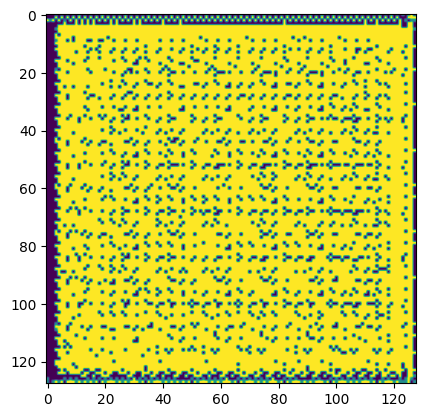

In [ ]:
from tensorflow.keras.utils import array_to_img

for img, mask in test_set.take(1):
    op = model.predict(img)

plt.imshow(array_to_img(np.argmax(op[2], axis = -1).reshape(128, 128, 1)))
plt.show()

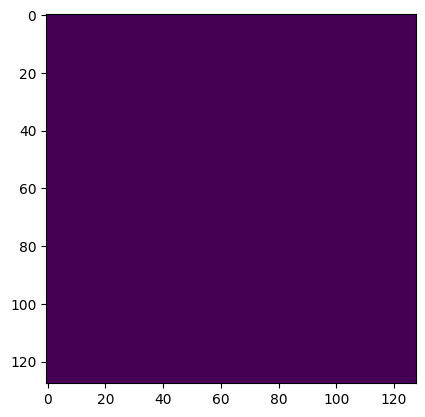

In [ ]:
plt.imshow(array_to_img(np.argmax(mask[2], axis = -1).reshape(128, 128, 1)))
plt.show()